8792
.\vehicles\vehicles\GTI_Far\image0000.png
8968


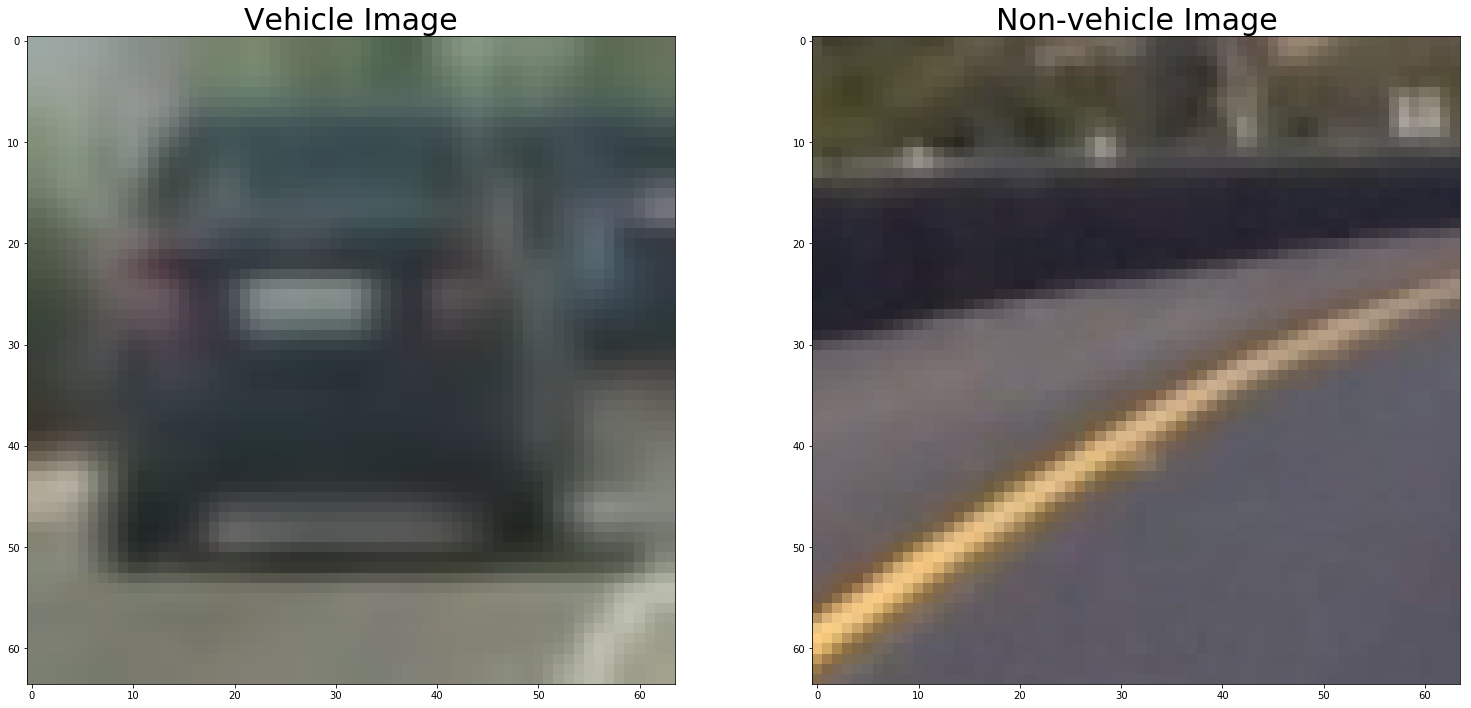

In [4]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

vehicles_dir = '.\\vehicles\\vehicles'
# Make a list of calibration images
vehicle_images = glob.glob(vehicles_dir + '\\**/*.png', recursive = True)
print(len(vehicle_images))
print(vehicle_images[0])
veh_img = mpimg.imread(vehicle_images[0])

non_vehicles_dir = '.\\non-vehicles\\non-vehicles'
# Make a list of calibration images
non_vehicle_images = glob.glob(non_vehicles_dir + '\\**/*.png', recursive = True)
print(len(non_vehicle_images))
non_veh_img = mpimg.imread(non_vehicle_images[5])

# Visualize images from each class
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(veh_img)
ax1.set_title('Vehicle Image', fontsize=30)
ax2.imshow(non_veh_img)
ax2.set_title('Non-vehicle Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("output_images\\veh_non_img.jpg")

(64, 64)
(64, 64, 3)
(1764,)


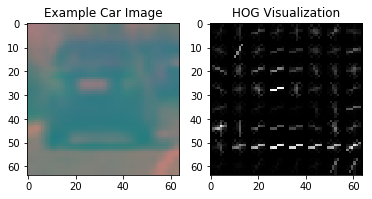

In [5]:
import cv2
from skimage.feature import hog
import numpy as np
       
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

# Generate a random index to look at a car image
#ind = np.random.randint(0, len(car_images))
#ind = 0 

gray = cv2.cvtColor(veh_img, cv2.COLOR_RGB2GRAY)
print(gray.shape)

veh_ycrcb = cv2.cvtColor(veh_img,cv2.COLOR_RGB2YCrCb)
print(veh_ycrcb.shape)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)
print (features.shape)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(veh_ycrcb, cmap='gray')
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [6]:
import pickle
from sklearn.preprocessing import StandardScaler

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1)):
     # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        #print(file)
        # Read in each one by one
        image = mpimg.imread(file)
        #print("Image:")
        #print(image.shape)
        
        '''gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        print("Gray:")
        print(gray.shape)'''
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)                
        else: feature_image = np.copy(image)
                
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print(type(spatial_features))
        #print(spatial_features.shape)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #print(type(hist_features))
        #print(hist_features.shape)
        
        # Get HOG features unraveled         
        hog_features = []
        
        for channel in range(feature_image.shape[2]):
            hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)
            #print(type(hog_feature))
            #print(hog_feature.shape)
            hog_features.append(hog_feature)            
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features[0], hog_features[1], hog_features[2])))
  
    # Return list of feature vectors
    return features
        
car_features = extract_features(vehicle_images, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1))
print(len(car_features))
notcar_features = extract_features(non_vehicle_images, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1))
print(len(notcar_features))

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
feature_pickle = {}
feature_pickle["car_features"] = car_features
feature_pickle["notcar_features"] = notcar_features
pickle.dump(feature_pickle, open( "feature_pickle.p", "wb" ))


8792
8968


In [ ]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(vehicle_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(vehicle_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')